<a href="https://colab.research.google.com/github/innosoft21/workspace/blob/main/tensorflow_python/Simple_CNN_horse_human_image_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2021-04-29 07:14:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   146MB/s    in 1.0s    

2021-04-29 07:14:13 (146 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



파일 시스템에 대한 액세스 권한을 제공하고 데이터 압축을 풀 수있는 zipfile 라이브러리를 사용합니다.

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

.zip의 컨텐츠는 기본 디렉토리로 추출되며, /tmp/horse-or-human차례로 각각 horses및 humans하위 디렉토리가 포함 됩니다.

요약 : 훈련 세트는 신경망 모델에 '이것은 말의 모습입니다', '이것은 인간의 모습입니다'등을 알리는 데 사용되는 데이터입니다.

이미지에 말이나 인간으로 명시 적으로 레이블을 지정하지 않습니다. 나중에 ImageGenerator라는 이름이 사용되는 것을 볼 수 있습니다.

In [3]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

이제 horses및 humans교육 디렉토리 에서 파일 이름이 어떻게 보이는지 살펴 보겠습니다 .

In [4]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse38-0.png', 'horse39-4.png', 'horse08-2.png', 'horse23-3.png', 'horse19-1.png', 'horse43-7.png', 'horse39-7.png', 'horse20-8.png', 'horse45-5.png', 'horse15-1.png']
['human16-04.png', 'human11-15.png', 'human15-10.png', 'human17-15.png', 'human15-11.png', 'human08-23.png', 'human10-11.png', 'human11-27.png', 'human15-22.png', 'human08-11.png']


디렉토리에있는 말과 사람 이미지의 총 수를 알아 봅시다.

In [5]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


이제 사진이 어떻게 생겼는지 더 잘 이해하기 위해 몇 장의 사진을 살펴 보겠습니다. 먼저 matplot 매개 변수를 구성합니다.

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

이제 8 개의 말과 8 개의 인간 사진을 표시합니다. 셀을 다시 실행하여 매번 새로운 배치를 볼 수 있습니다.

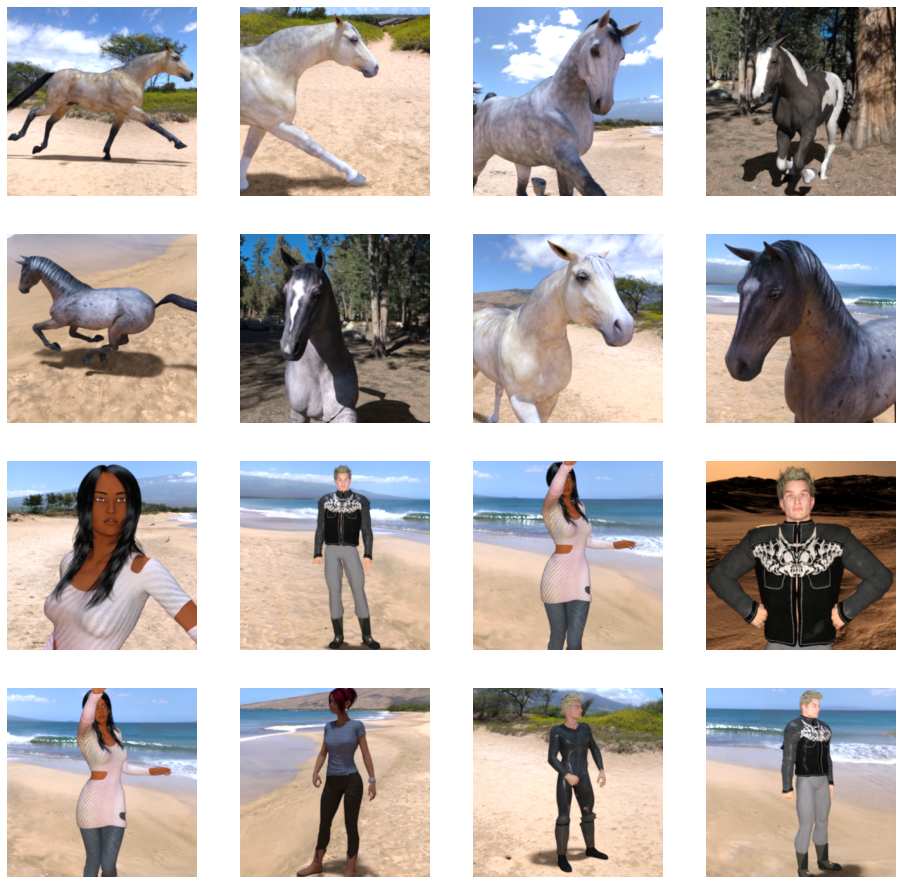

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
import tensorflow as tf

2 클래스 분류 문제, 즉 이진 분류 문제에 직면하고 있기 때문에 

sigmoid 활성화로 네트워크를 종료하여 네트워크 의 출력이 0과 1 사이의 단일 스칼라가 될 확률을 인코딩합니다.

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

"출력 형태"열은 각 연속 레이어에서 피쳐 맵의 크기가 어떻게 변화하는지 보여줍니다. 

컨볼 루션 레이어는 패딩으로 인해 피처 맵의 크기를 약간 줄이고 각 풀링 레이어는 차원을 반으로 줄입니다.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

binary_crossentropy이진 분류 문제이고 최종 활성화가 시그 모이 드이기 때문에 손실로 모델을 훈련 할 것 입니다. 

 rmsprop학습률이 0.001. 훈련 중에 분류 정확성을 모니터링하려고합니다.

 이 경우 RMSprop 최적화 알고리즘을 사용하는 것이 확률 적 경사 하강 법 (SGD)보다 선호됩니다.
 
 RMSprop은 학습 속도 조정을 자동화하기 때문입니다. 
 
 ( Adam 및 Adagrad 와 같은 다른 옵티마이 저도 훈련 중에 학습률을 자동으로 조정하며 여기서도 똑같이 잘 작동합니다.)

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

소스 폴더의 사진을 읽고, float32텐서 로 변환하고 , (레이블과 함께) 네트워크에 공급하는 데이터 생성기를 설정해 보겠습니다. 

 생성기는 300x300 크기의 이미지와 해당 레이블 (이진)을 생성합니다.

 픽셀 값을 [0, 1]범위 내에 있도록 정규화하여 이미지를 전처리 합니다

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 54s 6s/step - loss: 0.7073 - accuracy: 0.5097
Epoch 2/15
8/8 [==============================] - 53s 6s/step - loss: 0.6624 - accuracy: 0.7245
Epoch 3/15
8/8 [==============================] - 52s 6s/step - loss: 0.4016 - accuracy: 0.8297
Epoch 4/15
8/8 [==============================] - 52s 6s/step - loss: 0.4584 - accuracy: 0.8252
Epoch 5/15
8/8 [==============================] - 52s 6s/step - loss: 0.3362 - accuracy: 0.8490
Epoch 6/15
8/8 [==============================] - 52s 6s/step - loss: 0.2184 - accuracy: 0.9404
Epoch 7/15
8/8 [==============================] - 52s 6s/step - loss: 0.1217 - accuracy: 0.9577
Epoch 8/15
8/8 [==============================] - 59s 7s/step - loss: 0.1304 - accuracy: 0.9441
Epoch 9/15
8/8 [==============================] - 55s 7s/step - loss: 1.4161 - accuracy: 0.7822
Epoch 10/15
8/8 [==============================] - 59s 7s/step - loss: 0.1685 - accuracy: 0.9371
Epoch 11/15
8/8 [======================

이제 모델을 사용하여 실제로 예측을 실행하는 방법을 살펴 보겠습니다. 

이 코드를 사용하면 파일 시스템에서 하나 이상의 파일을 선택한 다음 업로드하고 모델을 통해 실행하여 개체가 말인지 사람인지를 표시합니다.

In [14]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

 convnet을 통과 할 때 어떻게 변환되는지 시각화

 훈련 세트에서 임의의 이미지를 선택한 다음 각 행이 레이어의 출력이고 
 
 행의 각 이미지가 해당 출력 특성 맵의 특정 필터 인 그림을 생성 해 보겠습니다.
 
 이 셀을 다시 실행하여 다양한 훈련 이미지에 대한 중간 표현을 생성합니다.

In [13]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


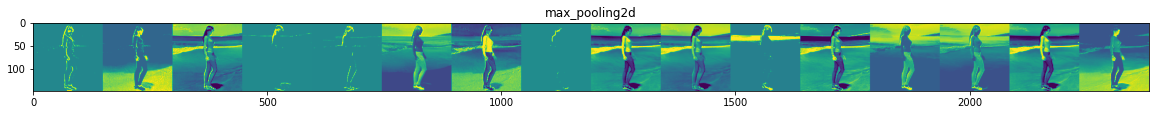

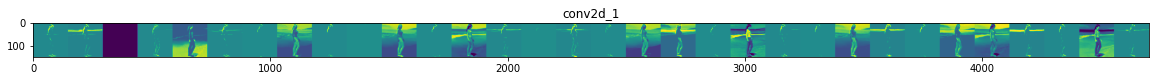

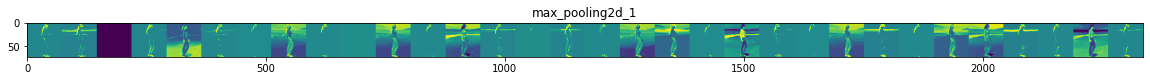

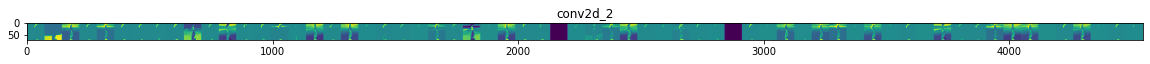

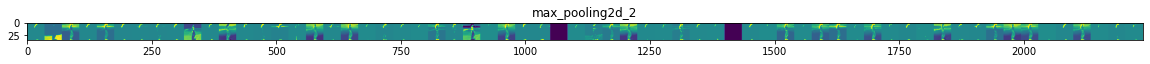

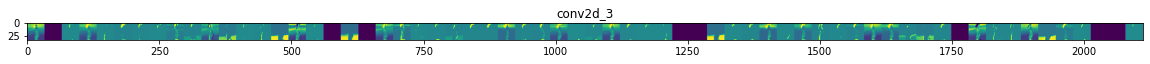

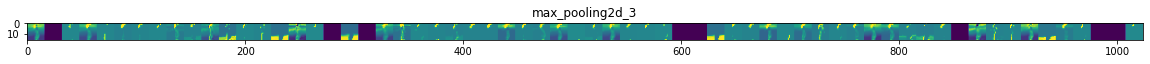

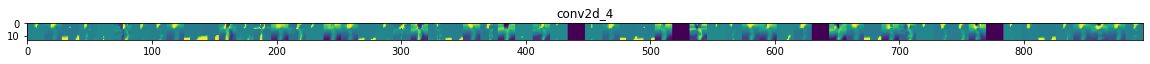

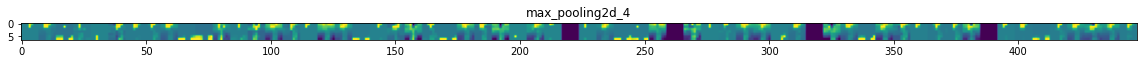

In [14]:
# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

보시다시피 이미지의 원시 픽셀에서 점점 추상적이고 간결한 표현으로 이동합니다.

다운 스트림 표현은 네트워크가주의를 기울이는 부분을 강조하기 시작하고 "활성화"되는 기능을 점점 더 적게 보여줍니다. 

대부분은 0으로 설정됩니다. 이를 "sparsity(희소성)"이라고합니다. 

표현 희소성은 딥 러닝의 핵심 기능입니다.

이러한 표현은 이미지의 원래 픽셀에 대한 정보를 점점 더 적게 전달하지만 이미지 클래스에 대한 정보는 점점 더 정제됩니다. 

convnet (또는 일반적으로 딥 네트워크)을 정보 증류 파이프 라인으로 생각할 수 있습니다.

In [15]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)